<VSCode-Cell-Markdown>
# Computer Assignment 1: (Integer) Linear Programming

This notebook contains the solutions for questions 1 and 3 of the assignment.
</VSCode-Cell-Markdown>

<VSCode-Cell-Markdown>
## Question 1: Diet Problem

Consider the prices and nutrients of the following foods in Table 1. You are interested in finding the cheapest diet that satisfies the following conditions (you can take fractions of servings):

-   Calories must be at least 2000,
-   Fat must be at least 50,
-   Protein must be at least 100,
-   Carbohydrates must be at least 250.

| Foods          | Price | Calories | Fat | Protein | Carbohydrate |
| :------------- | :---- | :------- | :-- | :------ | :----------- |
| Raw carrots    | 0.14  | 23       | 0.1 | 0.6     | 6            |
| Baked potatoes | 0.12  | 171      | 0.2 | 3.7     | 30           |
| Wheat bread    | 0.2   | 65       | 0   | 2.2     | 13           |
| Cheddar cheese | 0.75  | 112      | 9.3 | 7       | 0            |
| Peanut butter  | 0.15  | 188      | 16  | 7.7     | 2            |

**(a) (1 point) Formulate the linear optimization problem.**

**(b) (2 points) Solve the problem using linear optimization.**

**(c) (1 point) Only the first 5 units of peanut butter cost $0.15, above 5 units the price is $0.25 per unit. For example, 6 units cost 5 × $0.15 + 1 × $0.25 = $1.0. Model this in one linear model and solve it. Does it change the answer?**

**(d) (1 point) Solve the problem from a. when fractions of servings are not allowed anymore. Explain why this cheapest diet is less/more expensive than compared to when fractions where allowed.**

**(e) (2 points) Now instead of the requirement being to have at least the specified amount of nutrients the goal is to be as close as possible to the nutrient intake. So you should minimize the absolute differences. Furthermore, you are only allowed to use raw carrots, baked potatoes and wheat bread. The price is of no concern. You are still not allowed to use fractions of portions. Model and solve this problem.**
</VSCode-Cell-Markdown>

In [1]:
import pulp
import matplotlib.pyplot as plt

### Part 1b: Linear Programming (Fractional Servings)

Now, let's solve this using linear programming. Here, we assume we can have fractional servings (like 0.5 servings of bread).

In [2]:
# food data from the table - prices and nutritional info
foods = ['Raw carrots', 'Baked potatoes', 'Wheat bread', 'Cheddar cheese', 'Peanut butter']
prices = [0.14, 0.12, 0.2, 0.75, 0.15]
calories = [23, 171, 65, 112, 188]
fat = [0.1, 0.2, 0, 9.3, 16]
protein = [0.6, 3.7, 2.2, 7, 7.7]
carbs = [6, 30, 13, 0, 2]

# minimum daily requirements
min_calories = 2000
min_fat = 50
min_protein = 100
min_carbs = 250

# setting up the LP problem
prob_1b = pulp.LpProblem("Diet_Problem_1b", pulp.LpMinimize)

# decision variables - can be fractional
x = [pulp.LpVariable(f"x{i+1}", lowBound=0, cat='Continuous') for i in range(5)]

# objective: minimize total cost of the diet
prob_1b += pulp.lpSum([prices[i] * x[i] for i in range(5)]), "Total_Cost"

# constraints: make sure we meet all minimum nutrient requirements
prob_1b += pulp.lpSum([calories[i] * x[i] for i in range(5)]) >= min_calories, "Min_Calories"
prob_1b += pulp.lpSum([fat[i] * x[i] for i in range(5)]) >= min_fat, "Min_Fat"
prob_1b += pulp.lpSum([protein[i] * x[i] for i in range(5)]) >= min_protein, "Min_Protein"
prob_1b += pulp.lpSum([carbs[i] * x[i] for i in range(5)]) >= min_carbs, "Min_Carbs"

# solving it
prob_1b.solve(pulp.PULP_CBC_CMD(msg=0))

# displaying results
print("="*70)
print("QUESTION 1b: Linear Programming Solution (Fractions Allowed)")
print("="*70)
print("\nStatus:", pulp.LpStatus[prob_1b.status])
print("\nOptimal servings:")
for i, food in enumerate(foods):
    print(f"  {food}: {x[i].varValue:.4f} servings")

print(f"\nTotal cost: ${pulp.value(prob_1b.objective):.4f}")

# let's verify we actually met the requirements
total_cal = sum(calories[i] * x[i].varValue for i in range(5))
total_fat = sum(fat[i] * x[i].varValue for i in range(5))
total_prot = sum(protein[i] * x[i].varValue for i in range(5))
total_carb = sum(carbs[i] * x[i].varValue for i in range(5))

print("\nActual nutrient intake:")
print(f"  Calories: {total_cal:.2f} (minimum: {min_calories})")
print(f"  Fat: {total_fat:.2f} (minimum: {min_fat})")
print(f"  Protein: {total_prot:.2f} (minimum: {min_protein})")
print(f"  Carbohydrate: {total_carb:.2f} (minimum: {min_carbs})")

QUESTION 1b: Linear Programming Solution (Fractions Allowed)

Status: Optimal

Optimal servings:
  Raw carrots: 0.0000 servings
  Baked potatoes: 7.7147 servings
  Wheat bread: 0.0000 servings
  Cheddar cheese: 0.0000 servings
  Peanut butter: 9.2800 servings

Total cost: $2.3178

Actual nutrient intake:
  Calories: 3063.84 (minimum: 2000)
  Fat: 150.02 (minimum: 50)
  Protein: 100.00 (minimum: 100)
  Carbohydrate: 250.00 (minimum: 250)


### Part 1c: Peanut Butter with Tiered Pricing

What if the price of peanut butter changes? Let's say the first 5 servings are cheap ($0.15), but any serving after that is more expensive ($0.25). We can model this by splitting the peanut butter variable into two.

In [3]:
# setting up a new LP problem
prob_1c = pulp.LpProblem("Diet_Problem_1c", pulp.LpMinimize)

# decision variables for the first 4 foods (same as before)
x_1c = [pulp.LpVariable(f"x{i+1}_1c", lowBound=0, cat='Continuous') for i in range(4)]

# splitting peanut butter into two variables for the two price tiers
y1 = pulp.LpVariable("y1", lowBound=0, upBound=5, cat='Continuous')  # first 5 units at lower price
y2 = pulp.LpVariable("y2", lowBound=0, cat='Continuous')  # above 5 units at higher price

# objective with tiered pricing for peanut butter
prob_1c += (pulp.lpSum([prices[i] * x_1c[i] for i in range(4)]) + 
            0.15 * y1 + 0.25 * y2), "Total_Cost"

# constraints - total peanut butter is y1 + y2
prob_1c += (pulp.lpSum([calories[i] * x_1c[i] for i in range(4)]) + 
            calories[4] * (y1 + y2)) >= min_calories, "Min_Calories"
prob_1c += (pulp.lpSum([fat[i] * x_1c[i] for i in range(4)]) + 
            fat[4] * (y1 + y2)) >= min_fat, "Min_Fat"
prob_1c += (pulp.lpSum([protein[i] * x_1c[i] for i in range(4)]) + 
            protein[4] * (y1 + y2)) >= min_protein, "Min_Protein"
prob_1c += (pulp.lpSum([carbs[i] * x_1c[i] for i in range(4)]) + 
            carbs[4] * (y1 + y2)) >= min_carbs, "Min_Carbs"

# solving it
prob_1c.solve(pulp.PULP_CBC_CMD(msg=0))

# displaying results
print("\n" + "="*70)
print("QUESTION 1c: Peanut Butter with Price Tiers")
print("="*70)
print("First 5 units: $0.15/unit, above 5 units: $0.25/unit")
print("\nStatus:", pulp.LpStatus[prob_1c.status])
print("\nOptimal servings:")
for i in range(4):
    print(f"  {foods[i]}: {x_1c[i].varValue:.4f} servings")
print(f"  Peanut butter (first 5 units): {y1.varValue:.4f} servings")
print(f"  Peanut butter (above 5 units): {y2.varValue:.4f} servings")
print(f"  Peanut butter (total): {y1.varValue + y2.varValue:.4f} servings")

print(f"\nTotal cost: ${pulp.value(prob_1c.objective):.4f}")
print(f"Cost difference from 1b: ${pulp.value(prob_1c.objective) - pulp.value(prob_1b.objective):.4f}")


QUESTION 1c: Peanut Butter with Price Tiers
First 5 units: $0.15/unit, above 5 units: $0.25/unit

Status: Optimal

Optimal servings:
  Raw carrots: 0.0000 servings
  Baked potatoes: 16.6216 servings
  Wheat bread: 0.0000 servings
  Cheddar cheese: 0.0000 servings
  Peanut butter (first 5 units): 5.0000 servings
  Peanut butter (above 5 units): 0.0000 servings
  Peanut butter (total): 5.0000 servings

Total cost: $2.7446
Cost difference from 1b: $0.4268


### Part 1d: Integer Solution (No Fractions)

In reality, you can't really buy 0.78 servings of something. Let's re-run the optimization but restrict the servings to be whole numbers (integers). This is now an Integer Linear Programming (ILP) problem.

In [4]:
# setting up the ILP problem
prob_1d = pulp.LpProblem("Diet_Problem_1d", pulp.LpMinimize)

# decision variables - must be integers now (whole servings only)
x_1d = [pulp.LpVariable(f"x{i+1}_1d", lowBound=0, cat='Integer') for i in range(5)]

# objective function (same as 1b)
prob_1d += pulp.lpSum([prices[i] * x_1d[i] for i in range(5)]), "Total_Cost"

# constraints (same as 1b)
prob_1d += pulp.lpSum([calories[i] * x_1d[i] for i in range(5)]) >= min_calories, "Min_Calories"
prob_1d += pulp.lpSum([fat[i] * x_1d[i] for i in range(5)]) >= min_fat, "Min_Fat"
prob_1d += pulp.lpSum([protein[i] * x_1d[i] for i in range(5)]) >= min_protein, "Min_Protein"
prob_1d += pulp.lpSum([carbs[i] * x_1d[i] for i in range(5)]) >= min_carbs, "Min_Carbs"

# solving it
prob_1d.solve(pulp.PULP_CBC_CMD(msg=0))

# displaying results
print("\n" + "="*70)
print("QUESTION 1d: Integer Solution (No Fractions)")
print("="*70)
print("\nStatus:", pulp.LpStatus[prob_1d.status])
print("\nOptimal servings (integers only):")
for i, food in enumerate(foods):
    print(f"  {food}: {int(x_1d[i].varValue)} servings")

print(f"\nTotal cost: ${pulp.value(prob_1d.objective):.4f}")
print(f"Cost increase from 1b: ${pulp.value(prob_1d.objective) - pulp.value(prob_1b.objective):.4f}")

print("\nExplanation:")
print("The integer solution is more expensive because we cannot use fractional")
print("servings. This reduces flexibility and forces us to over-satisfy some")
print("nutrient requirements to meet all constraints with whole servings.")


QUESTION 1d: Integer Solution (No Fractions)

Status: Optimal

Optimal servings (integers only):
  Raw carrots: 0 servings
  Baked potatoes: 9 servings
  Wheat bread: 0 servings
  Cheddar cheese: 0 servings
  Peanut butter: 9 servings

Total cost: $2.4300
Cost increase from 1b: $0.1122

Explanation:
The integer solution is more expensive because we cannot use fractional
servings. This reduces flexibility and forces us to over-satisfy some
nutrient requirements to meet all constraints with whole servings.


### Part 1e: Minimize Absolute Differences

Now for a different goal. Instead of minimizing cost, let's try to get as close as possible to the nutritional targets, using only carrots, potatoes, and bread. We want to minimize the total deviation (both over and under) from each target.

In [5]:
# setting up the LP problem
prob_1e = pulp.LpProblem("Diet_Problem_1e", pulp.LpMinimize)

# decision variables - only first 3 foods allowed
x_1e = [pulp.LpVariable(f"x{i+1}_1e", lowBound=0, cat='Continuous') for i in range(3)]

# deviation variables for each nutrient (can go above or below target)
pos_cal = pulp.LpVariable("pos_cal", lowBound=0, cat='Continuous')
neg_cal = pulp.LpVariable("neg_cal", lowBound=0, cat='Continuous')

pos_fat = pulp.LpVariable("pos_fat", lowBound=0, cat='Continuous')
neg_fat = pulp.LpVariable("neg_fat", lowBound=0, cat='Continuous')

pos_prot = pulp.LpVariable("pos_prot", lowBound=0, cat='Continuous')
neg_prot = pulp.LpVariable("neg_prot", lowBound=0, cat='Continuous')

pos_carb = pulp.LpVariable("pos_carb", lowBound=0, cat='Continuous')
neg_carb = pulp.LpVariable("neg_carb", lowBound=0, cat='Continuous')

# objective: minimize total deviation from targets
prob_1e += (pos_cal + neg_cal + pos_fat + neg_fat + 
            pos_prot + neg_prot + pos_carb + neg_carb), "Total_Deviation"

# deviation constraints: actual - target = positive_dev - negative_dev
prob_1e += (pulp.lpSum([calories[i] * x_1e[i] for i in range(3)]) - min_calories == 
            pos_cal - neg_cal), "Cal_Deviation"
prob_1e += (pulp.lpSum([fat[i] * x_1e[i] for i in range(3)]) - min_fat == 
            pos_fat - neg_fat), "Fat_Deviation"
prob_1e += (pulp.lpSum([protein[i] * x_1e[i] for i in range(3)]) - min_protein == 
            pos_prot - neg_prot), "Prot_Deviation"
prob_1e += (pulp.lpSum([carbs[i] * x_1e[i] for i in range(3)]) - min_carbs == 
            pos_carb - neg_carb), "Carb_Deviation"

# solving it
prob_1e.solve(pulp.PULP_CBC_CMD(msg=0))

# displaying results
print("\n" + "="*70)
print("QUESTION 1e: Minimize Absolute Differences")
print("="*70)
print("Goal: Get as close as possible to nutrient targets")
print("Only raw carrots, baked potatoes, and wheat bread allowed")
print("\nStatus:", pulp.LpStatus[prob_1e.status])
print("\nOptimal servings:")
for i in range(3):
    print(f"  {foods[i]}: {x_1e[i].varValue:.4f} servings")

# calculating actual nutrient values
actual_cal = sum(calories[i] * x_1e[i].varValue for i in range(3))
actual_fat = sum(fat[i] * x_1e[i].varValue for i in range(3))
actual_prot = sum(protein[i] * x_1e[i].varValue for i in range(3))
actual_carb = sum(carbs[i] * x_1e[i].varValue for i in range(3))

print("\nActual nutrient intake vs. targets:")
print(f"  Calories: {actual_cal:.2f} (target: {min_calories}, deviation: {abs(actual_cal - min_calories):.2f})")
print(f"  Fat: {actual_fat:.2f} (target: {min_fat}, deviation: {abs(actual_fat - min_fat):.2f})")
print(f"  Protein: {actual_prot:.2f} (target: {min_protein}, deviation: {abs(actual_prot - min_protein):.2f})")
print(f"  Carbohydrate: {actual_carb:.2f} (target: {min_carbs}, deviation: {abs(actual_carb - min_carbs):.2f})")

print(f"\nTotal absolute deviation: {pulp.value(prob_1e.objective):.2f}")


QUESTION 1e: Minimize Absolute Differences
Goal: Get as close as possible to nutrient targets
Only raw carrots, baked potatoes, and wheat bread allowed

Status: Optimal

Optimal servings:
  Raw carrots: 0.0000 servings
  Baked potatoes: 11.6959 servings
  Wheat bread: 0.0000 servings

Actual nutrient intake vs. targets:
  Calories: 2000.00 (target: 2000, deviation: 0.00)
  Fat: 2.34 (target: 50, deviation: 47.66)
  Protein: 43.27 (target: 100, deviation: 56.73)
  Carbohydrate: 350.88 (target: 250, deviation: 100.88)

Total absolute deviation: 205.26


<VSCode-Cell-Markdown>
## Question 3: Inventory Management

A supply chain specialist has to manage a single-product inventory cost-efficiently for T periods onward. Because the specialist has to rent a warehouse, it costs h_t > 0 euro per product unit stored at time t. The ordering costs per product unit are c_t > 0 at time t. The demand at time t is estimated to be d_t and to provide good customer service, the specialist should ensure the demand can be met at every time. When new products are ordered at time t, they are directly available at time t. The initial stock level is given and denoted by s_0. Product amounts are integer. The model is in the file InventoryProblem.py. Change the model code to account for the following and solve the new problems respectively:

**(a) (2 points) The stock level cannot exceed 10.**

**(b) (2 points) Any leftovers at time T cost 3 euros as waste costs per unit (without change to the previous part).**

**(c) (2 points) For each time that you have more than 5 products in stock, you have to pay a fixed penalty of 8 euros to get some more space (so independent of the number of products above 5) (without changes to the previous parts)**
</VSCode-Cell-Markdown>

<VSCode-Cell-Markdown>
### Base Inventory Problem
</VSCode-Cell-Markdown>


Results for Base Problem:

Status: Optimal
s_1 = 12.0
s_2 = 8.0
s_3 = 0.0
s_4 = 0.0
s_5 = 3.0
s_6 = 1.0
s_7 = 0.0
x_1 = 9.0
x_2 = 0.0
x_3 = 0.0
x_4 = 10.0
x_5 = 7.0
x_6 = 0.0
x_7 = 0.0
Total costs =  284.0


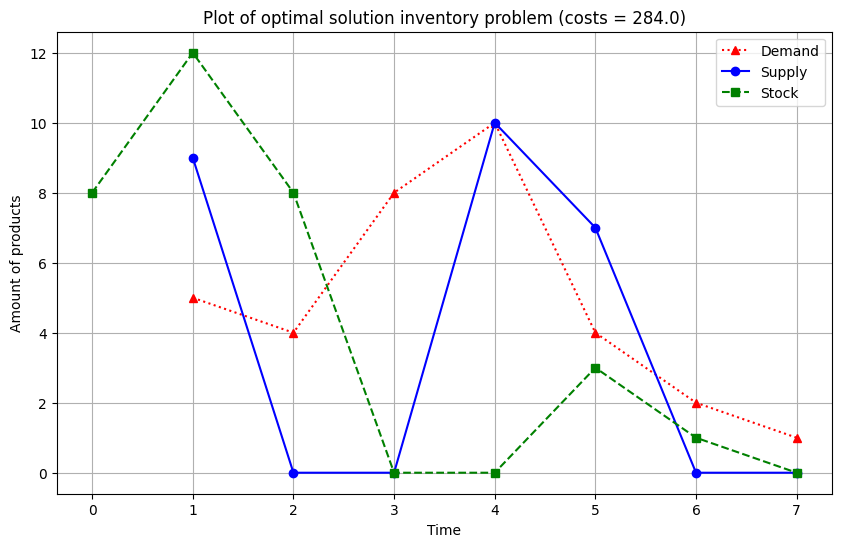

In [6]:
# problem data - basic inventory optimization
initial_stock = 8  # s_0, starting with 8 units already
demands = [None, 5, 4, 8, 10, 4, 2, 1]  # demands[t] = d_t for each period
holding_costs = [None, 1, 1, 1, 1, 1, 1, 1]  # holding_costs[t] = h_t (cost per unit held)
order_costs = [None, 10, 13, 13, 10, 10, 13, 13]  # order_costs[t] = c_t (cost per unit ordered)
max_periods = len(demands) - 1  # total number of periods (T)

# quick sanity check to make sure all arrays have the right length
assert len(holding_costs) == max_periods + 1, "lengths should be equal!"
assert len(order_costs) == max_periods + 1, "lengths should be equal!"

# setting up the optimization model
# ==================================

# creating the problem - we want to minimize total costs
ILO_problem = pulp.LpProblem("Inventory_problem", pulp.LpMinimize)

# variables we need to decide: how much to order and how much stock we'll have
supply = [None] + [pulp.LpVariable(f'x_{t}', cat='Integer', lowBound=0)
                   for t in range(1, max_periods + 1)]  # supply[t] = x_t
stock = [initial_stock] + [pulp.LpVariable(f's_{t}', cat='Integer', lowBound=0)
                           for t in range(1, max_periods + 1)]  # stock[t] = s_t

# our goal: minimize ordering costs + holding costs
ILO_problem += (pulp.lpDot(order_costs[1:], supply[1:]) +
                pulp.lpDot(holding_costs[1:], stock[1:])), "total_costs"

# adding constraints for each time period
for t in range(1, max_periods + 1):
    # this ensures inventory balance: stock now = stock before - demand + new supply
    constr_name = f"stock_balance_period_{t}"
    ILO_problem += stock[t] == stock[t - 1] - demands[t] + supply[t], constr_name

# solving the optimization problem
# =================================

# running the solver and displaying the model
print('\nResults for Base Problem:\n')
ILO_problem.solve(pulp.PULP_CBC_CMD(msg=False))
print("Status:", pulp.LpStatus[ILO_problem.status])

# showing all the decision variables with their optimal values
for v in ILO_problem.variables():
    print(v.name, "=", v.varValue)

# showing the total minimized cost
total_costs = ILO_problem.objective.value()
print("Total costs = ", total_costs)

# extracting values for plotting
supply_values = [None] + [el.value() for el in supply[1:]]
stock_values = [stock[0]] + [el.value() for el in stock[1:]]

# creating visualization
# ======================

# setting up the plot
plt.figure(figsize=(10, 6))

# plotting demand, supply, and stock levels over time
time_stamps = list(range(max_periods + 1))
plt.plot(time_stamps, demands, label='Demand', marker='^', linestyle=':',
         color='red')
plt.plot(time_stamps, supply_values, label='Supply', marker='o',
         linestyle='-', color='blue')
plt.plot(time_stamps, stock_values, label='Stock', marker='s',
         linestyle='--', color='green')

# adding labels and formatting
plt.xlabel('Time')
plt.ylabel('Amount of products')
plt.title(f'Plot of optimal solution inventory problem (costs = {total_costs})')
plt.legend()
plt.xticks(time_stamps)

# displaying the plot
plt.grid(True)
plt.show()

<VSCode-Cell-Markdown>
### (a) Stock Level Constraint
</VSCode-Cell-Markdown>


QUESTION 3a: Inventory Problem with Maximum Stock Constraint
Maximum stock level: 10 units

Solving...

Status: Optimal

Optimal solution:
Period | Supply | Stock | Demand
-------|--------|-------|-------
   1   |   7    |   10   |   5
   2   |   0    |   6   |   4
   3   |   2    |   0   |   8
   4   |   10    |   0   |   10
   5   |   7    |   3   |   4
   6   |   0    |   1   |   2
   7   |   0    |   0   |   1

Total costs = 286.0

Verification: Stock levels never exceed 10?
Maximum stock reached: 10
Constraint satisfied: YES

QUESTION 3a: Inventory Problem with Maximum Stock Constraint
Maximum stock level: 10 units

Solving...

Status: Optimal

Optimal solution:
Period | Supply | Stock | Demand
-------|--------|-------|-------
   1   |   7    |   10   |   5
   2   |   0    |   6   |   4
   3   |   2    |   0   |   8
   4   |   10    |   0   |   10
   5   |   7    |   3   |   4
   6   |   0    |   1   |   2
   7   |   0    |   0   |   1

Total costs = 286.0

Verification: Stock le

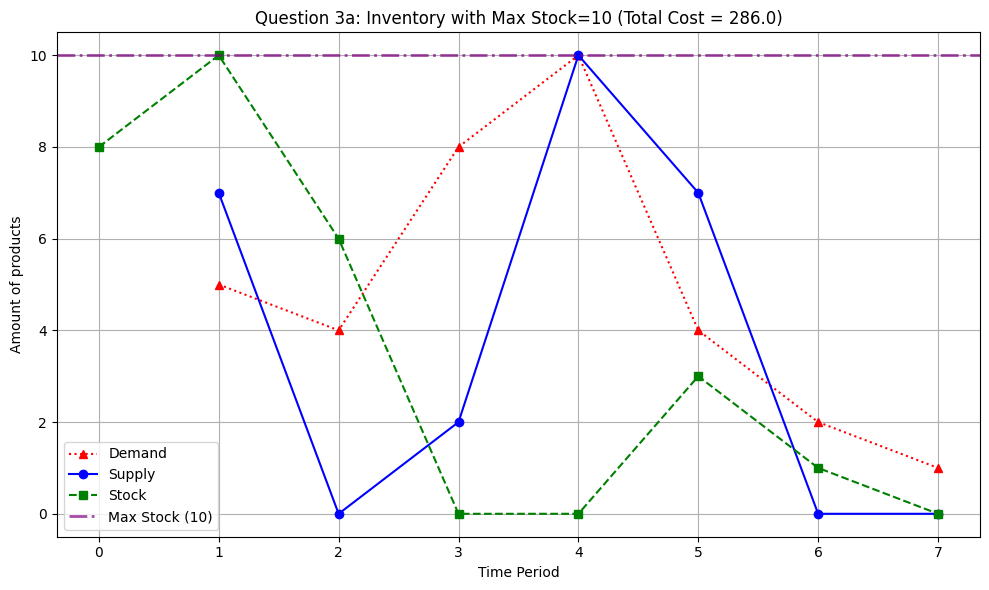

In [7]:
# problem data - starting with 8 units in stock already
initial_stock = 8  # s_0
demands = [None, 5, 4, 8, 10, 4, 2, 1]  # demands[t] = d_t for each period
holding_costs = [None, 1, 1, 1, 1, 1, 1, 1]  # holding_costs[t] = h_t (cost per unit held)
order_costs = [None, 10, 13, 13, 10, 10, 13, 13]  # order_costs[t] = c_t (cost per unit ordered)
max_periods = len(demands) - 1  # total number of periods (T)

# setting up the optimization model
# ==================================

# creating the problem - we want to minimize total costs
ILO_problem_3a = pulp.LpProblem("Inventory_3a_MaxStock", pulp.LpMinimize)

# variables we need to decide: how much to order and how much stock we'll have
supply_3a = [None] + [pulp.LpVariable(f'x_{t}', cat='Integer', lowBound=0)
                   for t in range(1, max_periods + 1)]
stock_3a = [initial_stock] + [pulp.LpVariable(f's_{t}', cat='Integer', lowBound=0)
                           for t in range(1, max_periods + 1)]

# our goal: minimize ordering costs + holding costs
ILO_problem_3a += (pulp.lpDot(order_costs[1:], supply_3a[1:]) +
                pulp.lpDot(holding_costs[1:], stock_3a[1:])), "total_costs"

# adding constraints for each time period
for t in range(1, max_periods + 1):
    # this ensures inventory balance: stock now = stock before - demand + new supply
    ILO_problem_3a += stock_3a[t] == stock_3a[t - 1] - demands[t] + supply_3a[t]
    
    # for part 3a: warehouse can't hold more than 10 units
    ILO_problem_3a += stock_3a[t] <= 10

# solving the optimization problem
# =================================

# running the solver to find optimal solution
print('\n' + '='*70)
print('QUESTION 3a: Inventory Problem with Maximum Stock Constraint')
print('='*70)
print('Maximum stock level: 10 units')
print('\nSolving...\n')

ILO_problem_3a.solve(pulp.PULP_CBC_CMD(msg=False))
print("Status:", pulp.LpStatus[ILO_problem_3a.status])

# displaying the results in a nice table format
print("\nOptimal solution:")
print("Period | Supply | Stock | Demand")
print("-------|--------|-------|-------")
for t in range(1, max_periods + 1):
    print(f"   {t}   |   {int(supply_3a[t].value())}    |   {int(stock_3a[t].value())}   |   {demands[t]}")

# calculating total cost
total_costs_3a = ILO_problem_3a.objective.value()
print(f"\nTotal costs = {total_costs_3a}")

# let's double-check that we never exceeded the max stock limit
print("\nVerification: Stock levels never exceed 10?")
max_stock_reached = max([stock_3a[t].value() for t in range(1, max_periods + 1)])
print(f"Maximum stock reached: {int(max_stock_reached)}")
print(f"Constraint satisfied: {'YES' if max_stock_reached <= 10 else 'NO'}")

# extracting values for plotting
supply_values_3a = [None] + [el.value() for el in supply_3a[1:]]
stock_values_3a = [stock_3a[0]] + [el.value() for el in stock_3a[1:]]

# creating visualization
# ======================

plt.figure(figsize=(10, 6))

# plotting demand, supply, and stock levels over time
time_stamps = list(range(max_periods + 1))
plt.plot(time_stamps, demands, label='Demand', marker='^', linestyle=':',
         color='red')
plt.plot(time_stamps, supply_values_3a, label='Supply', marker='o',
         linestyle='-', color='blue')
plt.plot(time_stamps, stock_values_3a, label='Stock', marker='s',
         linestyle='--', color='green')

# showing the max stock constraint line
plt.axhline(y=10, color='purple', linestyle='-.', linewidth=2, 
            label='Max Stock (10)', alpha=0.7)

plt.xlabel('Time Period')
plt.ylabel('Amount of products')
plt.title(f'Question 3a: Inventory with Max Stock=10 (Total Cost = {total_costs_3a})')
plt.legend()
plt.xticks(time_stamps)
plt.grid(True)
plt.tight_layout()
plt.show()

<VSCode-Cell-Markdown>
### (b) Waste Cost for Leftovers
</VSCode-Cell-Markdown>


QUESTION 3b: Inventory with Waste Cost
Maximum stock level: 10 units (from 3a)
Waste cost: 3 euros per unit at time T

Solving...

Status: Optimal

Optimal solution:
Period | Supply | Stock | Demand
-------|--------|-------|-------
   1   |   7    |   10   |   5
   2   |   0    |   6   |   4
   3   |   2    |   0   |   8
   4   |   10    |   0   |   10
   5   |   7    |   3   |   4
   6   |   0    |   1   |   2
   7   |   0    |   0   |   1

Cost breakdown:
  Order costs:   266
  Holding costs: 20
  Waste costs:   0 (3 euros × 0 units)
  Total costs:   286

Leftover stock at time T=7: 0 units


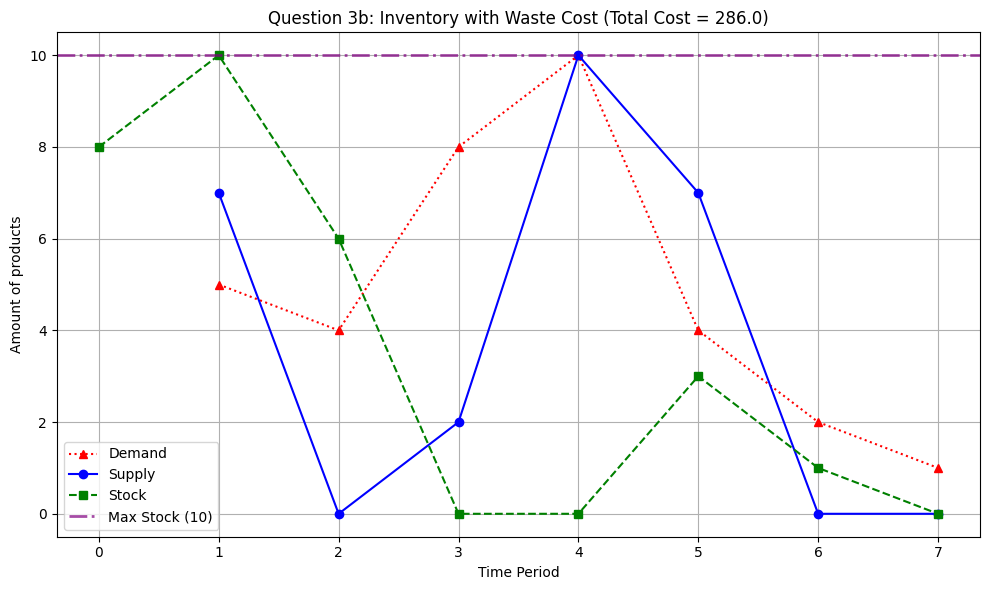

In [8]:
# problem data - same as before but now we care about leftover stock
initial_stock = 8  # s_0
demands = [None, 5, 4, 8, 10, 4, 2, 1]  # demands[t] = d_t for each period
holding_costs = [None, 1, 1, 1, 1, 1, 1, 1]  # holding_costs[t] = h_t (cost per unit held)
order_costs = [None, 10, 13, 13, 10, 10, 13, 13]  # order_costs[t] = c_t (cost per unit ordered)
max_periods = len(demands) - 1  # total number of periods (T)
waste_cost_per_unit = 3  # new: penalty for leftover stock at the end

# setting up the optimization model
# ==================================

# creating the problem - we want to minimize total costs
ILO_problem_3b = pulp.LpProblem("Inventory_3b_WasteCost", pulp.LpMinimize)

# variables we need to decide: how much to order and how much stock we'll have
supply_3b = [None] + [pulp.LpVariable(f'x_{t}', cat='Integer', lowBound=0)
                   for t in range(1, max_periods + 1)]
stock_3b = [initial_stock] + [pulp.LpVariable(f's_{t}', cat='Integer', lowBound=0)
                           for t in range(1, max_periods + 1)]

# our goal: minimize ordering costs + holding costs + waste cost at the end
# note: waste_cost_per_unit * stock[max_periods] penalizes leftover inventory
ILO_problem_3b += (pulp.lpDot(order_costs[1:], supply_3b[1:]) +
                pulp.lpDot(holding_costs[1:], stock_3b[1:]) +
                waste_cost_per_unit * stock_3b[max_periods]), "total_costs"

# adding constraints for each time period
for t in range(1, max_periods + 1):
    # this ensures inventory balance: stock now = stock before - demand + new supply
    ILO_problem_3b += stock_3b[t] == stock_3b[t - 1] - demands[t] + supply_3b[t]
    
    # keeping the max stock constraint from part 3a
    ILO_problem_3b += stock_3b[t] <= 10

# solving the optimization problem
# =================================

# running the solver to find optimal solution
print('\n' + '='*70)
print('QUESTION 3b: Inventory with Waste Cost')
print('='*70)
print('Maximum stock level: 10 units (from 3a)')
print('Waste cost: 3 euros per unit at time T')
print('\nSolving...\n')

ILO_problem_3b.solve(pulp.PULP_CBC_CMD(msg=False))
print("Status:", pulp.LpStatus[ILO_problem_3b.status])

# displaying the results in a nice table format
print("\nOptimal solution:")
print("Period | Supply | Stock | Demand")
print("-------|--------|-------|-------")
for t in range(1, max_periods + 1):
    print(f"   {t}   |   {int(supply_3b[t].value())}    |   {int(stock_3b[t].value())}   |   {demands[t]}")

# breaking down the different cost components to see what we're paying for
order_cost_total = sum(order_costs[t] * supply_3b[t].value() for t in range(1, max_periods + 1))
holding_cost_total = sum(holding_costs[t] * stock_3b[t].value() for t in range(1, max_periods + 1))
waste_cost_total = waste_cost_per_unit * stock_3b[max_periods].value()
total_costs_3b = ILO_problem_3b.objective.value()

print(f"\nCost breakdown:")
print(f"  Order costs:   {order_cost_total:.0f}")
print(f"  Holding costs: {holding_cost_total:.0f}")
print(f"  Waste costs:   {waste_cost_total:.0f} (3 euros × {int(stock_3b[max_periods].value())} units)")
print(f"  Total costs:   {total_costs_3b:.0f}")

print(f"\nLeftover stock at time T={max_periods}: {int(stock_3b[max_periods].value())} units")

# extracting values for plotting
supply_values_3b = [None] + [el.value() for el in supply_3b[1:]]
stock_values_3b = [stock_3b[0]] + [el.value() for el in stock_3b[1:]]

# creating visualization
# ======================

plt.figure(figsize=(10, 6))

# plotting demand, supply, and stock levels over time
time_stamps = list(range(max_periods + 1))
plt.plot(time_stamps, demands, label='Demand', marker='^', linestyle=':',
         color='red')
plt.plot(time_stamps, supply_values_3b, label='Supply', marker='o',
         linestyle='-', color='blue')
plt.plot(time_stamps, stock_values_3b, label='Stock', marker='s',
         linestyle='--', color='green')

# showing the max stock constraint line
plt.axhline(y=10, color='purple', linestyle='-.', linewidth=2, 
            label='Max Stock (10)', alpha=0.7)

plt.xlabel('Time Period')
plt.ylabel('Amount of products')
plt.title(f'Question 3b: Inventory with Waste Cost (Total Cost = {total_costs_3b})')
plt.legend()
plt.xticks(time_stamps)
plt.grid(True)
plt.tight_layout()
plt.show()

<VSCode-Cell-Markdown>
### (c) Fixed Penalty for High Stock
</VSCode-Cell-Markdown>


QUESTION 3c: Inventory with Storage Penalty
Maximum stock level: 10 units (from 3a)
Waste cost: 3 euros per unit at time T (from 3b)
Storage penalty: 5 euros when stock > 5 (NEW)

Solving...

Status: Optimal

Optimal solution:
Period | Supply | Stock | Demand | Penalty?
-------|--------|-------|--------|----------
   1   |   2    |   5   |   5     | NO
   2   |   0    |   1   |   4     | NO
   3   |   7    |   0   |   8     | NO
   4   |   10    |   0   |   10     | NO
   5   |   7    |   3   |   4     | NO
   6   |   0    |   1   |   2     | NO
   7   |   0    |   0   |   1     | NO

Cost breakdown:
  Order costs:    281
  Holding costs:  10
  Waste costs:    0 (3 euros × 0 units)
  Storage penalty: 0 (5 euros × 0 periods)
  Total costs:    291

Periods with stock > 5: 0
Leftover stock at time T=7: 0 units


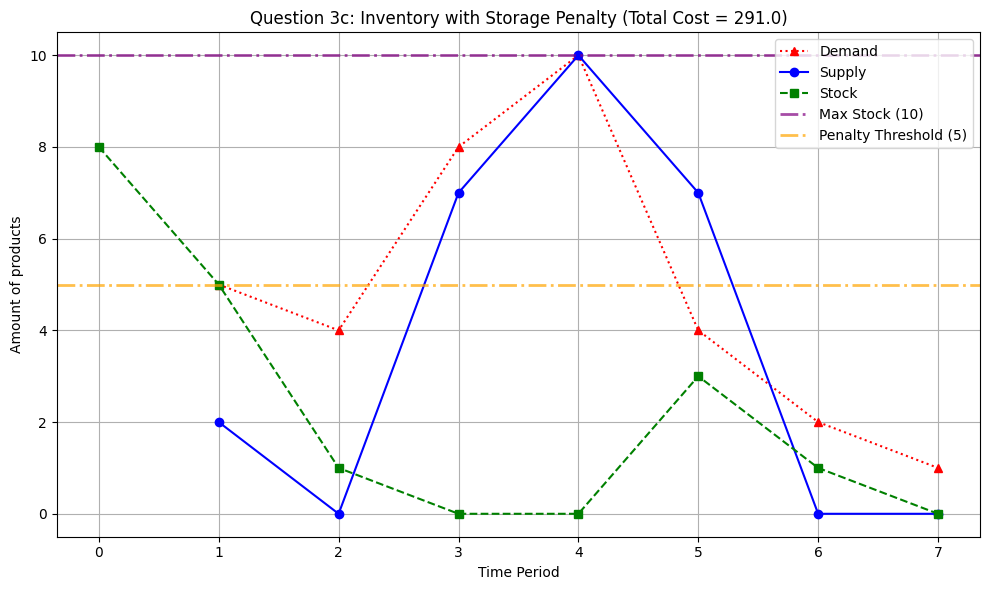

In [9]:
# problem data - now with an extra penalty for keeping too much stock
initial_stock = 8  # s_0
demands = [None, 5, 4, 8, 10, 4, 2, 1]  # demands[t] = d_t for each period
holding_costs = [None, 1, 1, 1, 1, 1, 1, 1]  # holding_costs[t] = h_t (cost per unit held)
order_costs = [None, 10, 13, 13, 10, 10, 13, 13]  # order_costs[t] = c_t (cost per unit ordered)
max_periods = len(demands) - 1  # total number of periods (T)
waste_cost_per_unit = 3  # penalty for leftover stock at the end (from 3b)
storage_penalty = 5  # new: extra penalty each period when stock > 5
M = 1000  # big-M constant for linearization trick

# setting up the optimization model
# ==================================

# creating the problem - we want to minimize total costs
ILO_problem_3c = pulp.LpProblem("Inventory_3c_StoragePenalty", pulp.LpMinimize)

# variables we need to decide: how much to order and how much stock we'll have
supply_3c = [None] + [pulp.LpVariable(f'x_{t}', cat='Integer', lowBound=0)
                   for t in range(1, max_periods + 1)]
stock_3c = [initial_stock] + [pulp.LpVariable(f's_{t}', cat='Integer', lowBound=0)
                           for t in range(1, max_periods + 1)]

# binary indicators: will be 1 if stock exceeds 5, 0 otherwise
# we need these to trigger the penalty only when stock > 5
indicator = [None] + [pulp.LpVariable(f'ind_{t}', cat='Binary')
                      for t in range(1, max_periods + 1)]

# our goal: minimize all costs including the new storage penalty
ILO_problem_3c += (pulp.lpDot(order_costs[1:], supply_3c[1:]) +
                pulp.lpDot(holding_costs[1:], stock_3c[1:]) +
                waste_cost_per_unit * stock_3c[max_periods] +
                storage_penalty * pulp.lpSum(indicator[1:])), "total_costs"

# adding constraints for each time period
for t in range(1, max_periods + 1):
    # this ensures inventory balance: stock now = stock before - demand + new supply
    ILO_problem_3c += stock_3c[t] == stock_3c[t - 1] - demands[t] + supply_3c[t]
    
    # keeping the max stock constraint from part 3a
    ILO_problem_3c += stock_3c[t] <= 10
    
    # this is the clever part: if stock[t] > 5, then indicator[t] must be 1
    # the constraint is: stock[t] <= 5 + M * indicator[t]
    # when stock is 5 or less, indicator can be 0; when stock > 5, indicator must be 1
    ILO_problem_3c += stock_3c[t] <= 5 + M * indicator[t]

# solving the optimization problem
# =================================

# running the solver to find optimal solution
print('\n' + '='*70)
print('QUESTION 3c: Inventory with Storage Penalty')
print('='*70)
print('Maximum stock level: 10 units (from 3a)')
print('Waste cost: 3 euros per unit at time T (from 3b)')
print('Storage penalty: 5 euros when stock > 5 (NEW)')
print('\nSolving...\n')

ILO_problem_3c.solve(pulp.PULP_CBC_CMD(msg=False))
print("Status:", pulp.LpStatus[ILO_problem_3c.status])

# displaying the results - now with penalty information too
print("\nOptimal solution:")
print("Period | Supply | Stock | Demand | Penalty?")
print("-------|--------|-------|--------|----------")
for t in range(1, max_periods + 1):
    penalty_flag = "YES" if indicator[t].value() == 1 else "NO"
    print(f"   {t}   |   {int(supply_3c[t].value())}    |   {int(stock_3c[t].value())}   |   {demands[t]}     | {penalty_flag}")

# breaking down all the different cost components
order_cost_total = sum(order_costs[t] * supply_3c[t].value() for t in range(1, max_periods + 1))
holding_cost_total = sum(holding_costs[t] * stock_3c[t].value() for t in range(1, max_periods + 1))
waste_cost_total = waste_cost_per_unit * stock_3c[max_periods].value()
penalty_count = sum(indicator[t].value() for t in range(1, max_periods + 1))
penalty_cost_total = storage_penalty * penalty_count
total_costs_3c = ILO_problem_3c.objective.value()

print(f"\nCost breakdown:")
print(f"  Order costs:    {order_cost_total:.0f}")
print(f"  Holding costs:  {holding_cost_total:.0f}")
print(f"  Waste costs:    {waste_cost_total:.0f} (3 euros × {int(stock_3c[max_periods].value())} units)")
print(f"  Storage penalty: {penalty_cost_total:.0f} (5 euros × {int(penalty_count)} periods)")
print(f"  Total costs:    {total_costs_3c:.0f}")

print(f"\nPeriods with stock > 5: {int(penalty_count)}")
print(f"Leftover stock at time T={max_periods}: {int(stock_3c[max_periods].value())} units")

# extracting values for plotting
supply_values_3c = [None] + [el.value() for el in supply_3c[1:]]
stock_values_3c = [stock_3c[0]] + [el.value() for el in stock_3c[1:]]

# creating visualization
# ======================

plt.figure(figsize=(10, 6))

# plotting demand, supply, and stock levels over time
time_stamps = list(range(max_periods + 1))
plt.plot(time_stamps, demands, label='Demand', marker='^', linestyle=':',
         color='red')
plt.plot(time_stamps, supply_values_3c, label='Supply', marker='o',
         linestyle='-', color='blue')
plt.plot(time_stamps, stock_values_3c, label='Stock', marker='s',
         linestyle='--', color='green')

# showing both constraint lines (max stock and penalty threshold)
plt.axhline(y=10, color='purple', linestyle='-.', linewidth=2, 
            label='Max Stock (10)', alpha=0.7)
plt.axhline(y=5, color='orange', linestyle='-.', linewidth=2, 
            label='Penalty Threshold (5)', alpha=0.7)

plt.xlabel('Time Period')
plt.ylabel('Amount of products')
plt.title(f'Question 3c: Inventory with Storage Penalty (Total Cost = {total_costs_3c})')
plt.legend()
plt.xticks(time_stamps)
plt.grid(True)
plt.tight_layout()
plt.show()